# Surrogate Construction for Genz Functions with regression as a function of the number of training points

This notebook constructs a PC surrogate for Genz functions using random sampling and regression, giving the RMS error bewteen the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *
import PyUQTk.uqtkarray as uqtkarray

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 8          # Order of the PCE
pc_type = "LU"     # Polynomial type
pc_alpha = 0.0     # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 10000       # Number of evaluation samples samples
#max_dim=6         # Maximum number of dimensions to include
model= 'genz_ppeak'  # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

First, we define the random number generator.

## Collecting Errors

We loop through different numbers of random samples to feed into regression and obtain the RMSE. We start with a number of samples equal to 90% of the basis terms and continue to 125%.

In [3]:
sigma = np.array([1.e-08]) # inital noise variance; updated in BCS
#eta = 1e-6                 # threshold for stopping the algorithm
lambda_init = np.array([]) # set lambda to a fixed nonnegative value

scale = 0.1     # diagonal loading parameter
adaptive = 1    # generative basis for adaptive CS, 0 or 1
optimal = 1     # use the rigorous implementation of adaptive CS, 0 or 1

ndim=6

In [5]:
percent=[.6, .7, .8, .9, 1, 1.10, 1.2, 1.3, 1.4, 1.5, 1.9, 2] # fractions of the number of basis terms to use
#etas=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
#etas=[1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
etas=[1e-5, 1e-6, 1e-7]

neta=len(etas)
# arrays to store error statistics for each dimension
mean_dim_errors=np.zeros((neta, len(percent)))
std_dim_errors=np.zeros((neta, len(percent)))

# instantiate PC object
pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
npce=pc_model.GetNumberPCTerms()
# instantiate random generator
rng = qmc.LatinHypercube(d=ndim, seed=42)
coef=np.random.normal(0, 5, npce)

# loop through each dimension
for j, eta in enumerate(etas):
    print("eta", eta)
    
    # list to store stats for each percent
    mean_per_errors=[]
    std_per_errors=[]

    for per in percent:
        nTest=int(npce*per)
        
        # list to store stats for the 10 trials
        RMSE_list=[]
        
        for i in range(10):
            # train PC at random samples
            
            rand=2*rng.random(n=nTest)-1
            
            f_evals=pce_tools.UQTkEvaluatePCE(pc_model, coef, rand)
            
            # find coefficients
            c_k = pce_tools.UQTkBCS(pc_model, f_evals, rand, sigma, eta, lambda_init, adaptive, optimal, scale)
            
            # evaluate at random samples
            germ_samples=2*rng.random(n=nSam)-1
            pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
         
            # find error
            f_actual=pce_tools.UQTkEvaluatePCE(pc_model, coef, germ_samples)
            MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
            RMSE=math.sqrt(MSE)
            RMSE_list.append(RMSE)
            
            
        # add the results of the 10 trials    
        mean_per_errors.append(np.array(RMSE_list).mean())
        std_per_errors.append(np.std(np.array(RMSE_list)))
        
    mean_dim_errors[j]=mean_per_errors
    std_dim_errors[j]=std_per_errors

eta 1e-05
eta 1e-06
eta 1e-07


## Summary
This table and figure display the error of each number of training points for each dimension. The number of training points varies as a percentage of the number of basis terms.

In [6]:
row_label=["eta "+str(i) for i in range(neta)]
pd.DataFrame(data=mean_dim_errors, index=row_label, columns=percent)

,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.9,2.0
eta 0,28.381723,26.904775,25.807745,25.156890,24.424458,23.825668,23.243158,23.032623,22.113670,21.752290,20.812452,21.418279
eta 1,27.947055,26.018370,24.096902,23.176344,22.398441,21.549489,20.476835,20.206398,19.098481,19.135545,17.724107,16.219815
eta 2,27.320590,24.625973,22.780569,21.033974,20.269005,19.160983,17.704776,18.367031,17.230347,17.476043,15.534932,14.653607


In [7]:
len(etas)

3

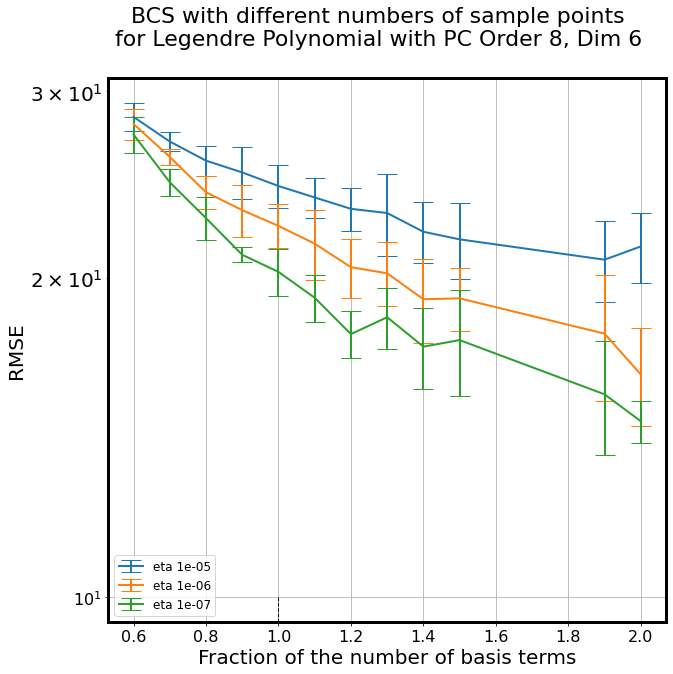

In [8]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot Error Data
for i in range(neta):
    plt.errorbar(percent, mean_dim_errors[i], yerr=std_dim_errors[i], xerr=None, linewidth=2, markersize=8, capsize=10, label=str('eta '+str(etas[i])))

# Line where number of samples = number of basis terms
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'black', linestyle="dashed")

# Label Axes
plt.xlabel("Fraction of the number of basis terms",fontsize=20)
plt.ylabel("RMSE",fontsize=20)

# Create legend
plt.legend(loc='lower left')

# Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

# Add title
fig.suptitle("BCS with different numbers of sample points\nfor Legendre Polynomial with\
 PC Order %s, Dim %s"%(str(nord), str(ndim)), fontsize=22)

# Change y scale
plt.yscale('log')

#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 